# Control variable

In [1]:
import random
import numpy as np
import torch

rd_seed = 42

torch.manual_seed(rd_seed)
np.random.seed(rd_seed)
random.seed(rd_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/dacon/medicine/data/train.csv')

train_df.head()

Mounted at /content/drive


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3496 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


## Smiles data visualization

In [4]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 54.1 MB/s eta 0:00:00


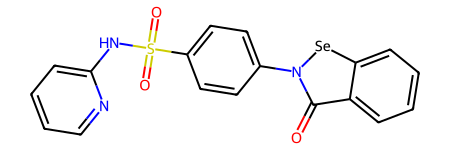

In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

mol = Chem.MolFromSmiles(train_df['SMILES'][1000])
mol

# Graph Convolutional Network Model

In [6]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=00bdd6e4370e1dfbfba640cab9263ad2111b6e7605eea5d9dc299769d78449d2
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GraphFeature(nn.Module):
    def __init__(self, node_feat, embed_dim):
        super(GraphFeature, self).__init__()

        self.conv_l1 = GCNConv(node_feat, 8)
        self.conv_l2 = GCNConv(8, 16)
        self.embedding = nn.Linear(16, embed_dim)

    def forward(self, x, edge_idx, batch):
        x = F.elu(self.conv_l1(x, edge_idx))
        x = F.elu(self.conv_l2(x, edge_idx))

        x = global_mean_pool(x, batch) # read-out layer

        x = self.embedding(x)

        return x

# Tabnet Encoder for gpu training

In [8]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 957.1 kB/s eta 0:00:00


In [9]:
from pytorch_tabnet.tab_network import AttentiveTransformer, FeatTransformer

class TabNetEncoder(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_d=8,
        n_a=8,
        n_steps=3,
        gamma=1.3,
        n_independent=2,
        n_shared=2,
        epsilon=1e-15,
        virtual_batch_size=128,
        momentum=0.02,
        mask_type="sparsemax",
        group_attention_matrix=None,
        device='cpu'
    ):

        super(TabNetEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_multi_task = isinstance(output_dim, list)
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.virtual_batch_size = virtual_batch_size
        self.mask_type = mask_type
        self.initial_bn = nn.BatchNorm1d(self.input_dim, momentum=0.01)
        self.group_attention_matrix = group_attention_matrix
        self.device = device

        if self.group_attention_matrix is None:
            # no groups
            self.group_attention_matrix = torch.eye(self.input_dim).to(self.device)
            self.attention_dim = self.input_dim
        else:
            self.attention_dim = self.group_attention_matrix.shape[0]

        if self.n_shared > 0:
            shared_feat_transform = nn.ModuleList()
            for i in range(self.n_shared):
                if i == 0:
                    shared_feat_transform.append(
                        nn.Linear(self.input_dim, 2 * (n_d + n_a), bias=False)
                    )
                else:
                    shared_feat_transform.append(
                        nn.Linear(n_d + n_a, 2 * (n_d + n_a), bias=False)
                    )

        else:
            shared_feat_transform = None

        self.initial_splitter = FeatTransformer(
            self.input_dim,
            n_d + n_a,
            shared_feat_transform,
            n_glu_independent=self.n_independent,
            virtual_batch_size=self.virtual_batch_size,
            momentum=momentum,
        )

        self.feat_transformers = nn.ModuleList()
        self.att_transformers = nn.ModuleList()

        for step in range(n_steps):
            transformer = FeatTransformer(
                self.input_dim,
                n_d + n_a,
                shared_feat_transform,
                n_glu_independent=self.n_independent,
                virtual_batch_size=self.virtual_batch_size,
                momentum=momentum,
            )
            attention = AttentiveTransformer(
                n_a,
                self.attention_dim,
                group_matrix=group_attention_matrix,
                virtual_batch_size=self.virtual_batch_size,
                momentum=momentum,
                mask_type=self.mask_type,
            )
            self.feat_transformers.append(transformer)
            self.att_transformers.append(attention)

    def forward(self, x, prior=None):
        x = self.initial_bn(x)

        bs = x.shape[0]  # batch size
        if prior is None:
            prior = torch.ones((bs, self.attention_dim)).to(x.device)

        M_loss = 0
        att = self.initial_splitter(x)[:, self.n_d :]
        steps_output = []
        for step in range(self.n_steps):
            M = self.att_transformers[step](prior, att)
            M_loss += torch.mean(
                torch.sum(torch.mul(M, torch.log(M + self.epsilon)), dim=1)
            )
            # update prior
            prior = torch.mul(self.gamma - M, prior)
            # output
            M_feature_level = torch.matmul(M, self.group_attention_matrix)
            masked_x = torch.mul(M_feature_level, x)
            out = self.feat_transformers[step](masked_x)
            d = nn.ReLU()(out[:, : self.n_d])
            steps_output.append(d)
            # update attention
            att = out[:, self.n_d :]

        M_loss /= self.n_steps
        return steps_output, M_loss

    def forward_masks(self, x):
        x = self.initial_bn(x)
        bs = x.shape[0]  # batch size
        prior = torch.ones((bs, self.attention_dim)).to(x.device)
        M_explain = torch.zeros(x.shape).to(x.device)
        att = self.initial_splitter(x)[:, self.n_d :]
        masks = {}

        for step in range(self.n_steps):
            M = self.att_transformers[step](prior, att)
            M_feature_level = torch.matmul(M, self.group_attention_matrix)
            masks[step] = M_feature_level
            # update prior
            prior = torch.mul(self.gamma - M, prior)
            # output
            masked_x = torch.mul(M_feature_level, x)
            out = self.feat_transformers[step](masked_x)
            d = nn.ReLU()(out[:, : self.n_d])
            # explain
            step_importance = torch.sum(d, dim=1)
            M_explain += torch.mul(M_feature_level, step_importance.unsqueeze(dim=1))
            # update attention
            att = out[:, self.n_d :]

        return M_explain, masks

# Multimodal (GNN / Tabnet)

In [10]:
class GraphTab(nn.Module):
    def __init__(self, graph_dict, tabnet_dict, num_heads, reg_emb, drop_ratio, out_dim, device='cpu'):
        super(GraphTab, self).__init__()

        self.device = device

        self.graph_feature = GraphFeature(graph_dict['node_feat'], graph_dict['embed_dim'])
        self.tabnet_feature = TabNetEncoder(input_dim =     tabnet_dict['input_dim'],
                                            output_dim =    tabnet_dict['output_dim'],
                                            n_d =           tabnet_dict['n_da'],
                                            n_a =           tabnet_dict['n_da'],
                                            n_steps =       tabnet_dict['n_steps'],
                                            device =        self.device)

        self.attn_layer = nn.MultiheadAttention(graph_dict['embed_dim'], num_heads, dropout=drop_ratio)

        self.regressor = nn.Sequential(nn.Linear(graph_dict['embed_dim'], reg_emb),
                                       nn.BatchNorm1d(reg_emb),
                                       nn.ELU(),
                                       nn.Dropout(p=drop_ratio),
                                       nn.Linear(reg_emb, reg_emb),
                                       nn.BatchNorm1d(reg_emb),
                                       nn.ELU(),
                                       nn.Dropout(p=drop_ratio),
                                       nn.Linear(reg_emb, out_dim))

    def forward(self, node_attr, edge_idx, batch, tabular):
        gr_ft = self.graph_feature(node_attr, edge_idx, batch) # (batch, embed_dim)
        tab_ft = self.tabnet_feature(tabular) # return tuple(list of tensor (batch, n_a))

        tab_ft = torch.sum(torch.stack(tab_ft[0]), dim=0)
        # tab_ft = torch.squeeze(tab_ft, 0)

        gr_ft.to(self.device)
        tab_ft.to(self.device)

        attn_output = self.attn_layer(gr_ft, gr_ft, tab_ft) # (batch, pos_emb)
        attn_output = attn_output[0]

        res = self.regressor(attn_output)
        return res

# Custom dataset

In [11]:
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles

'''
graph data (x, edge_index) / tabular data (without "smiles") / mlm / hlm
'''

class MultiDataset(Dataset):
    def __init__(self, tabular_path):
        super(MultiDataset, self).__init__()

        self.train_df = pd.read_csv(tabular_path)
        self.train_df.fillna(0, inplace=True)
        self.graph_list = self.smiles2mol(train_df['SMILES'])

        self.target_mlm = torch.tensor(self.train_df['MLM'].values.astype(np.float32))
        self.target_hlm = torch.tensor(self.train_df['HLM'].values.astype(np.float32))

        self.wo_smiles_df = self.train_df.drop(columns=['SMILES', 'id', 'MLM', 'HLM'])
        self.wo_smiles_df = torch.tensor(self.wo_smiles_df.values.astype(np.float32))

    def smiles2mol(self, smiles_list):
        print('Convert "SMILES" data to mol')

        graph_list = []
        for smiles in tqdm(smiles_list):
            graph_data = from_smiles(smiles)

            graph_data.smiles = None
            graph_data.edge_attr = None

            graph_list.append(graph_data)

        print('Complete!')
        return graph_list

    def __getitem__(self, idx):
        return self.graph_list[idx], self.wo_smiles_df[idx], self.target_mlm[idx], self.target_hlm[idx]

    def __len__(self):
        return len(self.graph_list)

In [12]:
test_dataset = MultiDataset('/content/drive/MyDrive/dacon/medicine/data/train.csv')
test_loader = DataLoader(test_dataset, batch_size=128)

print()
print(len(test_dataset))

Convert "SMILES" data to mol


  0%|          | 0/3498 [00:00<?, ?it/s]

Complete!

3498


# Model Training

## RMSE class

In [13]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_hat, y):
        loss = torch.sqrt(self.mse(y_hat,y))
        return loss

In [14]:
graph_params = {
    'node_feat': 9,
    'embed_dim': 32
}

tabnet_params = {
    'input_dim': 7,
    'output_dim': 0,
    'n_da': 32, # output dimension
    'n_steps': 3,
}

model = GraphTab(graph_dict=graph_params,
                 tabnet_dict=tabnet_params,
                 num_heads=4,
                 reg_emb=32,
                 drop_ratio=0.1,
                 out_dim=1,
                 device='cuda')

In [15]:
EPOCHS = 100
model.to(device='cuda')

criterion = RMSELoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

losses = []

model.train()
for ep in range(EPOCHS):
    ep_loss = 0
    for gr, tr_df, mlm_target, _ in test_loader:
        gr_x = gr.x.type(torch.float32).to('cuda')
        gr_edge_idx = gr.edge_index.to('cuda')
        gr_batch = gr.batch.to('cuda')

        tabular = tr_df.to('cuda')
        mlm_target = mlm_target.view(-1, 1).to('cuda')

        optimizer.zero_grad()
        predict = model(gr_x, gr_edge_idx, gr_batch, tabular)

        loss = criterion(predict, mlm_target)
        loss.backward()
        ep_loss = loss.item()

        optimizer.step()
    losses.append(ep_loss)

    print(f'Epoch: {ep+1} / rmse: {ep_loss}')

Epoch: 1 / rmse: 36.062374114990234
Epoch: 2 / rmse: 36.04082107543945
Epoch: 3 / rmse: 36.02698516845703
Epoch: 4 / rmse: 36.00157928466797
Epoch: 5 / rmse: 36.01526641845703
Epoch: 6 / rmse: 35.864627838134766
Epoch: 7 / rmse: 35.92002487182617
Epoch: 8 / rmse: 36.000614166259766
Epoch: 9 / rmse: 36.08976745605469
Epoch: 10 / rmse: 36.00018310546875
Epoch: 11 / rmse: 36.00251007080078
Epoch: 12 / rmse: 35.92230224609375
Epoch: 13 / rmse: 35.943946838378906
Epoch: 14 / rmse: 35.87481689453125
Epoch: 15 / rmse: 35.93366622924805
Epoch: 16 / rmse: 35.89201736450195
Epoch: 17 / rmse: 35.997886657714844
Epoch: 18 / rmse: 35.886600494384766
Epoch: 19 / rmse: 35.934356689453125
Epoch: 20 / rmse: 35.91043472290039
Epoch: 21 / rmse: 35.87882995605469
Epoch: 22 / rmse: 35.856719970703125
Epoch: 23 / rmse: 35.90704345703125
Epoch: 24 / rmse: 35.80730056762695
Epoch: 25 / rmse: 35.91981887817383
Epoch: 26 / rmse: 35.79069519042969
Epoch: 27 / rmse: 35.85420608520508
Epoch: 28 / rmse: 35.92073059